In [ ]:
import yfinance as yf
import statsmodels 
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import nasdaqdatalink as ndl
plt.style.use('seaborn-darkgrid')

In [9]:
ticker = 'SPY'
spy = yf.download(ticker, start = '2014-01-01' , end ='2019-12-31')
spy = pd.DataFrame(spy)
spy

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,183.979996,184.070007,182.479996,182.919998,154.400192,119636900
2014-01-03,183.229996,183.600006,182.630005,182.889999,154.374908,81390600
2014-01-06,183.490005,183.559998,182.080002,182.360001,153.927490,108028200
2014-01-07,183.089996,183.789993,182.949997,183.479996,154.872910,86144200
2014-01-08,183.449997,183.830002,182.889999,183.520004,154.906738,96582300
...,...,...,...,...,...,...
2019-12-23,321.589996,321.649994,321.059998,321.220001,305.051208,52990000
2019-12-24,321.470001,321.519989,320.899994,321.230011,305.060699,20270000
2019-12-26,321.649994,322.950012,321.640015,322.940002,306.684631,30911200


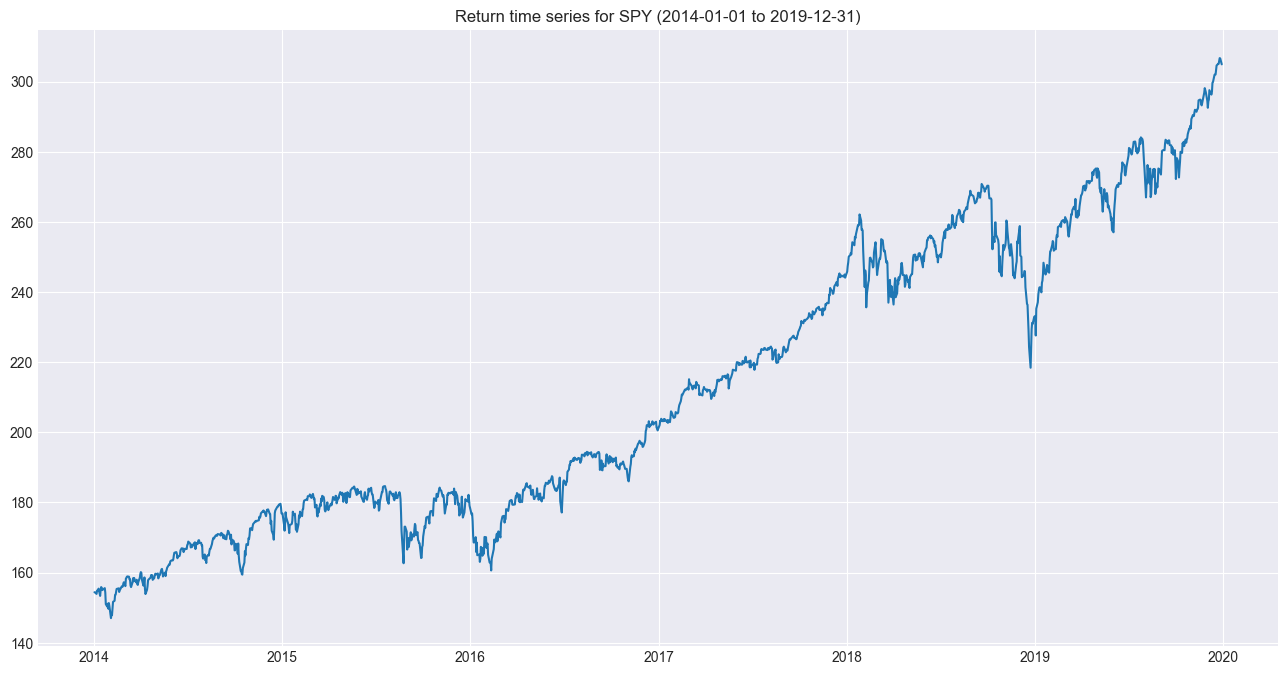

In [10]:

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Return time series for SPY (2014-01-01 to 2019-12-31)')
plt.plot(spy['Adj Close'])

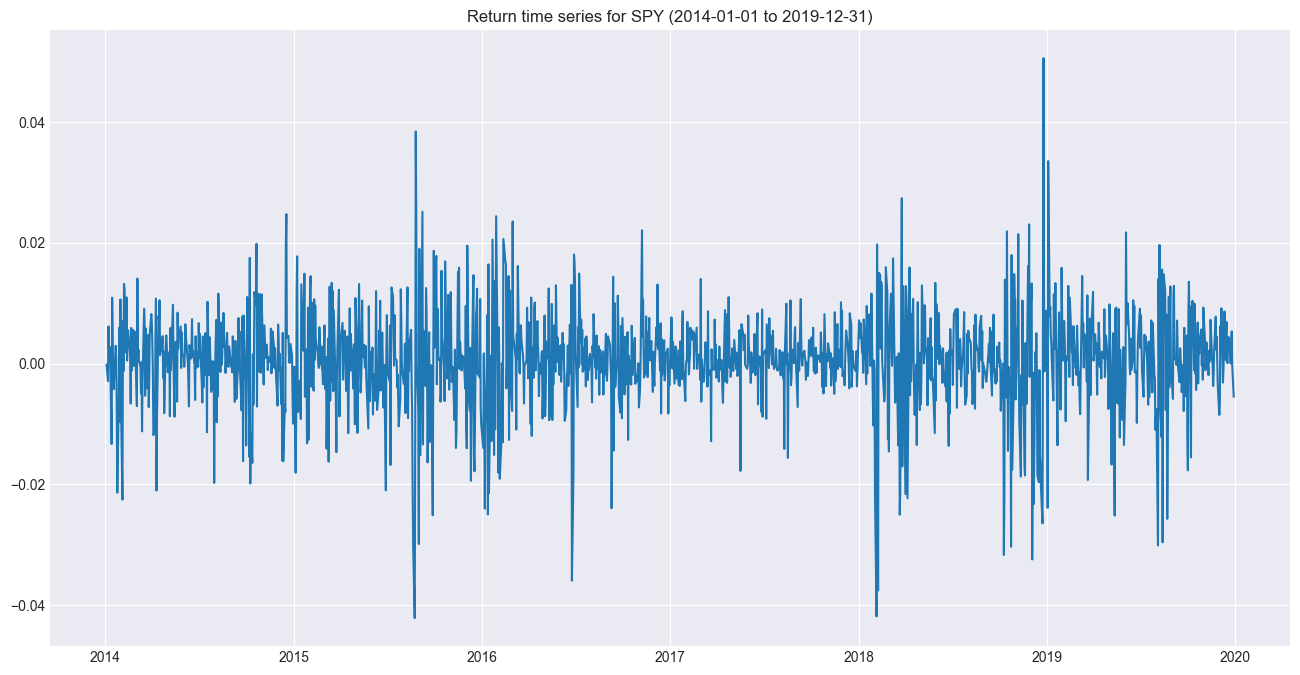

In [11]:
# Calculate the daily return (spy pays dividends, so we use Adj Close)

spy['Return'] = spy['Adj Close'].pct_change()

# plot the daily return

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Return time series for SPY (2014-01-01 to 2019-12-31)')
plt.plot(spy['Return'])


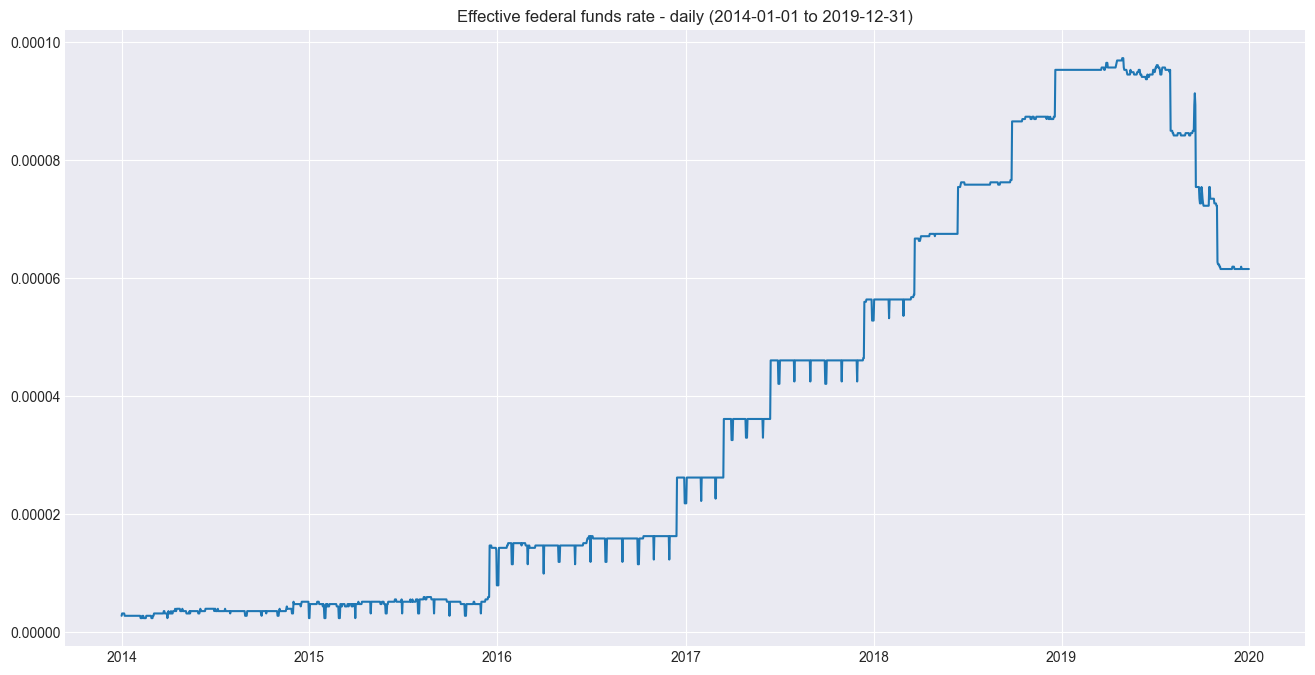

In [12]:
# download effective federal funds rate, already daily
effr = ndl.get("FRED/DFF", start_date = '2014-01-01' , end_date ='2019-12-31')
effr

#plot effective federal funds rate

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Effective federal funds rate - daily (2014-01-01 to 2019-12-31)')
plt.plot(effr['Value']/(100*252))

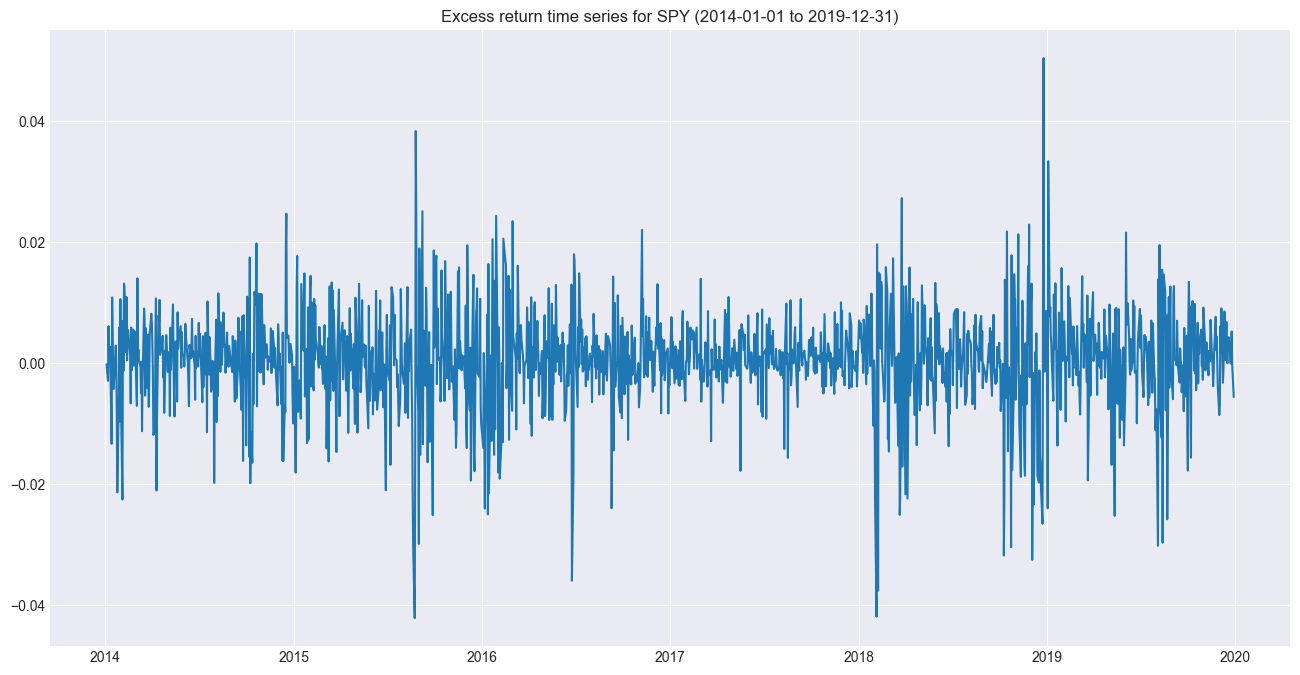

In [13]:
# excess returns

spy['Excess Return'] = spy['Return'] - (effr['Value']/(100*252))
spy['Daily interest rate'] = effr['Value']/(100*252)
# plot excess returns

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Excess return time series for SPY (2014-01-01 to 2019-12-31)')
plt.plot(spy['Excess Return'])

In [ ]:
def trend_follow_ma(df, leverage, initial_cap):
    df['MA-short'] = df['Excess Return'].rolling(7).mean()
    df['MA-long'] = df['Excess Return'].rolling(20).mean()
    df['Signal'] = np.where(df['MA-short'] > df['MA-long'], leverage, 0)
    #df['Signal'] = np.where(df['MA-short'] < df['MA-long']-0.01, -leverage, df['Signal'])
    df['Signal'] = np.where(df['MA-long'].isnull(), 0, df['Signal'])
    df['Strategy Return'] = df['Signal'].shift(1) * df['Excess Return']
    df['Cash'] = (1+df['Strategy Return']).cumprod() * initial_cap
    df['PnL'] = df['Cash'].diff()
    return df

train_set_len = int(len(spy)*0.7)
spy_train = spy[:train_set_len]
spy_test = spy[train_set_len:]



spy_train = trend_follow_ma(spy_train, 5, 200000)
spy_test = trend_follow_ma(spy_test, 5, 200000)



# plot the strategy return

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Position, upper and lower bounds - Trend Following Strategy')
plt.plot(spy_train['Cash']*5, label= 'Upper bound - train')
plt.plot(spy_train['Cash']*spy_train['Signal'], label= 'Position - train')
plt.plot(spy_train['Cash']*-5, label= 'Lower bound - train')
plt.plot(spy_test['Cash']*5, label  = 'Upper bound - test')
plt.plot(spy_test['Cash']*spy_test['Signal'], label= 'Position - test')
plt.plot(spy_test['Cash']*-5, label= 'Lower bound - test')
plt.legend(loc='upper left')
#plt.plot(spy['Excess Return'])


In [15]:
spy_train

,Open,High,Low,Close,Adj Close,Volume,Return,Excess Return,Daily interest rate,MA-short,MA-long,Signal,Strategy Return,Cash,PnL
Date,,,,,,,,,,,,,,,
2014-01-02,183.979996,184.070007,182.479996,182.919998,154.400192,119636900,NaN,NaN,0.000003,NaN,NaN,0,NaN,NaN,NaN
2014-01-03,183.229996,183.600006,182.630005,182.889999,154.374908,81390600,-0.000164,-0.000167,0.000003,NaN,NaN,0,-0.000000,200000.000000,NaN
2014-01-06,183.490005,183.559998,182.080002,182.360001,153.927490,108028200,-0.002898,-0.002901,0.000003,NaN,NaN,0,-0.000000,200000.000000,0.000000
2014-01-07,183.089996,183.789993,182.949997,183.479996,154.872910,86144200,0.006142,0.006139,0.000003,NaN,NaN,0,0.000000,200000.000000,0.000000
2014-01-08,183.449997,183.830002,182.889999,183.520004,154.906738,96582300,0.000218,0.000216,0.000003,NaN,NaN,0,0.000000,200000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-07,270.420013,273.179993,270.200012,272.779999,249.496170,87063500,-0.000366,-0.000423,0.000056,-0.002667,0.000701,0,-0.000000,601070.197006,0.000000
2018-03-08,273.549988,274.239990,272.420013,274.100006,250.703476,66901200,0.004839,0.004783,0.000056,-0.000192,0.001214,0,0.000000,601070.197006,0.000000
2018-03-09,275.700012,278.869995,275.339996,278.869995,255.066315,113625300,0.017402,0.017346,0.000056,0.003741,0.003960,0,0.000000,601070.197006,0.000000


In [16]:
#Calculate the turnover in dollar value traded over time
def turnover(spy):
    turnover_cash = (spy['Cash']*spy['Signal']).diff().abs().sum()

    a = ((spy['Cash']*spy['Signal'])/spy['Adj Close'])
    b = (spy['Cash']*spy['Signal'].shift(1)/spy['Adj Close'].shift(1))
    turnover_units = ((((spy['Cash']*spy['Signal'])/spy['Adj Close']))
                    -((spy['Cash']*spy['Signal'].shift(1)/spy['Adj Close'].shift(1)))).abs().sum()

    print(turnover_cash, turnover_units)

turnover(spy_train)
turnover(spy_test)

300591308.07936966 1490267.3369608582
93710000.56412621 334261.18812717963


In [ ]:
#compute total pnl where money is invested in the market when the signal is 0
def total_pnl(df, initial_cap):
    df['Total strategy return'] = np.where(df['Signal'].shift(1) == 0, df['Daily interest rate'], df['Strategy Return'])
    df['Total strategy cash'] = (1+df['Total strategy return']).cumprod() * initial_cap
    df['Total PnL'] = df['Total strategy cash'].diff()
    return df

spy_train = total_pnl(spy_train, 200000)
spy_test = total_pnl(spy_test, 200000)



/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_39765/2102030298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_train['Capital PnL'] = np.where(spy_train['Signal'].shift(1) == 0, spy_train['Total PnL'], 0)
/var/folders/qx/wm8zvdn9565d9zck2z8rg25m0000gn/T/ipykernel_39765/2102030298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_test['Capital PnL'] = np.where(spy_test['Signal'].shift(1) == 0, spy_test['Total PnL'], 0)


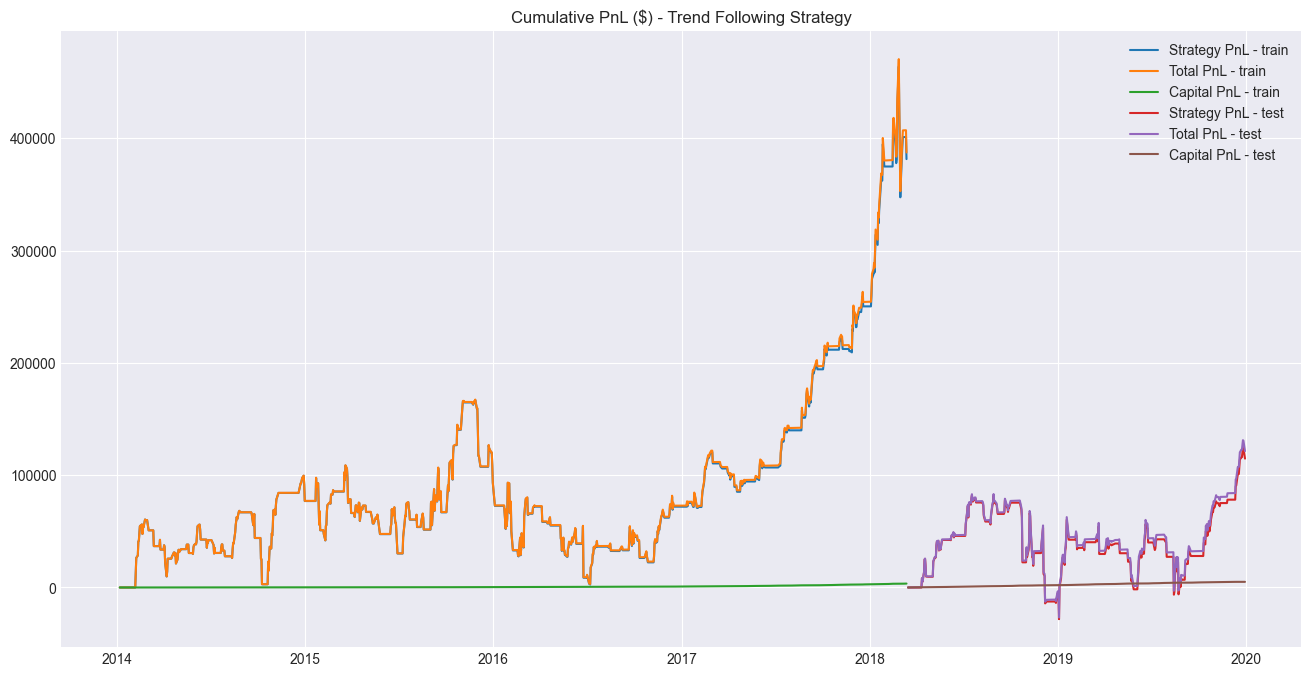

In [18]:
#plot cumulative pnl, total pnl 

spy_train['Capital PnL'] = np.where(spy_train['Signal'].shift(1) == 0, spy_train['Total PnL'], 0)
spy_test['Capital PnL'] = np.where(spy_test['Signal'].shift(1) == 0, spy_test['Total PnL'], 0)

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Cumulative PnL ($) - Trend Following Strategy')
plt.plot(spy_train['PnL'].cumsum(), label = 'Strategy PnL - train')
plt.plot(spy_train['Total PnL'].cumsum(), label = 'Total PnL - train')
plt.plot(spy_train['Capital PnL'].cumsum(), label = 'Capital PnL - train')
plt.plot(spy_test['PnL'].cumsum(), label = 'Strategy PnL - test')
plt.plot(spy_test['Total PnL'].cumsum(), label = 'Total PnL - test')
plt.plot(spy_test['Capital PnL'].cumsum(), label = 'Capital PnL - test')
plt.legend()





In [19]:
spy_test

,Open,High,Low,Close,Adj Close,Volume,Return,Excess Return,Daily interest rate,MA-short,MA-long,Signal,Strategy Return,Cash,PnL,Total strategy return,Total strategy cash,Total PnL,Capital PnL
Date,,,,,,,,,,,,,,,,,,,
2018-03-14,277.809998,278.019989,274.670013,275.299988,251.801010,105895100,-0.005131,-0.005188,0.000056,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2018-03-15,275.880005,276.609985,274.429993,275.000000,251.526672,83433000,-0.001090,-0.001146,0.000057,NaN,NaN,0,-0.000000,200000.000000,NaN,0.000057,200011.349206,NaN,NaN
2018-03-16,274.500000,275.390015,274.140015,274.200012,251.799393,100343700,0.001084,0.001028,0.000057,NaN,NaN,0,0.000000,200000.000000,0.000000,0.000057,200022.699057,11.349850,11.349850
2018-03-19,273.350006,274.399994,268.619995,270.489990,248.392456,109208400,-0.013530,-0.013587,0.000057,NaN,NaN,0,-0.000000,200000.000000,0.000000,0.000057,200034.049551,11.350494,11.350494
2018-03-20,270.940002,271.670013,270.179993,270.950012,248.814926,59757300,0.001701,0.001644,0.000057,NaN,NaN,0,0.000000,200000.000000,0.000000,0.000057,200045.480068,11.430517,11.430517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,321.589996,321.649994,321.059998,321.220001,305.051208,52990000,0.001528,0.001466,0.000062,0.002476,0.001820,5,0.007332,316043.966506,2300.283280,0.007332,322741.563965,2349.030837,0.000000
2019-12-24,321.470001,321.519989,320.899994,321.230011,305.060699,20270000,0.000031,-0.000030,0.000062,0.002395,0.001434,5,-0.000152,315995.935351,-48.031155,-0.000152,322692.514934,-49.049031,0.000000
2019-12-26,321.649994,322.950012,321.640015,322.940002,306.684631,30911200,0.005323,0.005262,0.000062,0.002174,0.001587,5,0.026309,324309.471597,8313.536246,0.026309,331182.231475,8489.716541,0.000000


In [34]:

print(a/b)

0.7703533740601214


In [20]:
# compute the Sharpe ratio

def annualised_sharpe_ratio(df):
    return (df['Strategy Return'].mean()*252)/(df['Strategy Return'].std()*np.sqrt(252))

print(annualised_sharpe_ratio(spy_train))
print(annualised_sharpe_ratio(spy_test))

# compute the sortino ratio

def annualised_sortino_ratio(df):
    return (df['Strategy Return'].mean()*252)/(df['Strategy Return'][df['Strategy Return']<0].std()*np.sqrt(252))

print(annualised_sortino_ratio(spy_train))
print(annualised_sortino_ratio(spy_test))

# compute the max drawdown

def max_drawdown(df):
    comp_ret = (df['Strategy Return']+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

print(max_drawdown(spy_train))
print(max_drawdown(spy_test))
# compute the calmar ratio

def calmar_ratio(df):
    return (df['Strategy Return'].mean()*252)/abs(max_drawdown(df))

print(calmar_ratio(spy_train))
print(calmar_ratio(spy_test))



0.8816773155175527
0.8126026636782456
0.7982214003624863
0.5949226506173907
-0.44779834855847667
-0.39081896296297824
0.7193201777163394
0.884352412909067


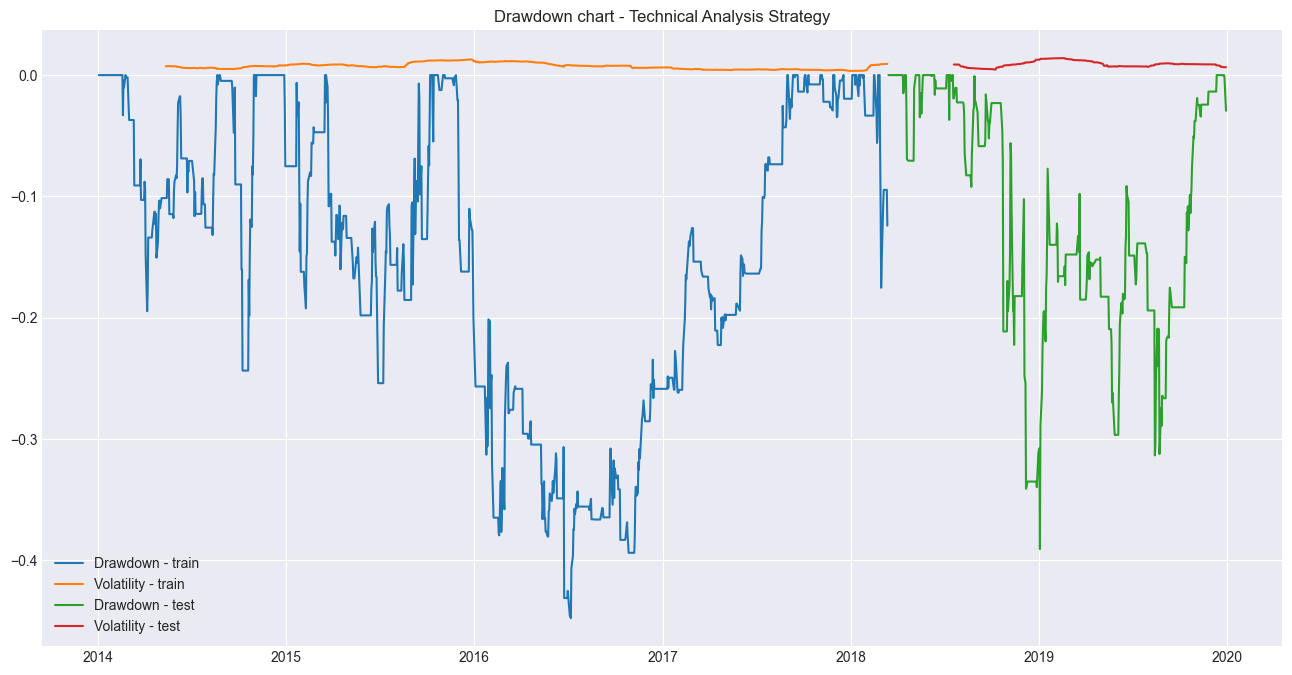

In [21]:
plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Drawdown chart - Technical Analysis Strategy')
plt.plot(-(spy_train['Cash'].cummax() - spy_train['Cash'])/spy_train['Cash'].cummax(), label = 'Drawdown - train')
plt.plot(spy_train['Return'].rolling(90).std(), label = 'Volatility - train')
plt.plot(-(spy_test['Cash'].cummax() - spy_test['Cash'])/spy_test['Cash'].cummax(), label = 'Drawdown - test')
plt.plot(spy_test['Return'].rolling(90).std(), label = 'Volatility - test')
plt.legend()

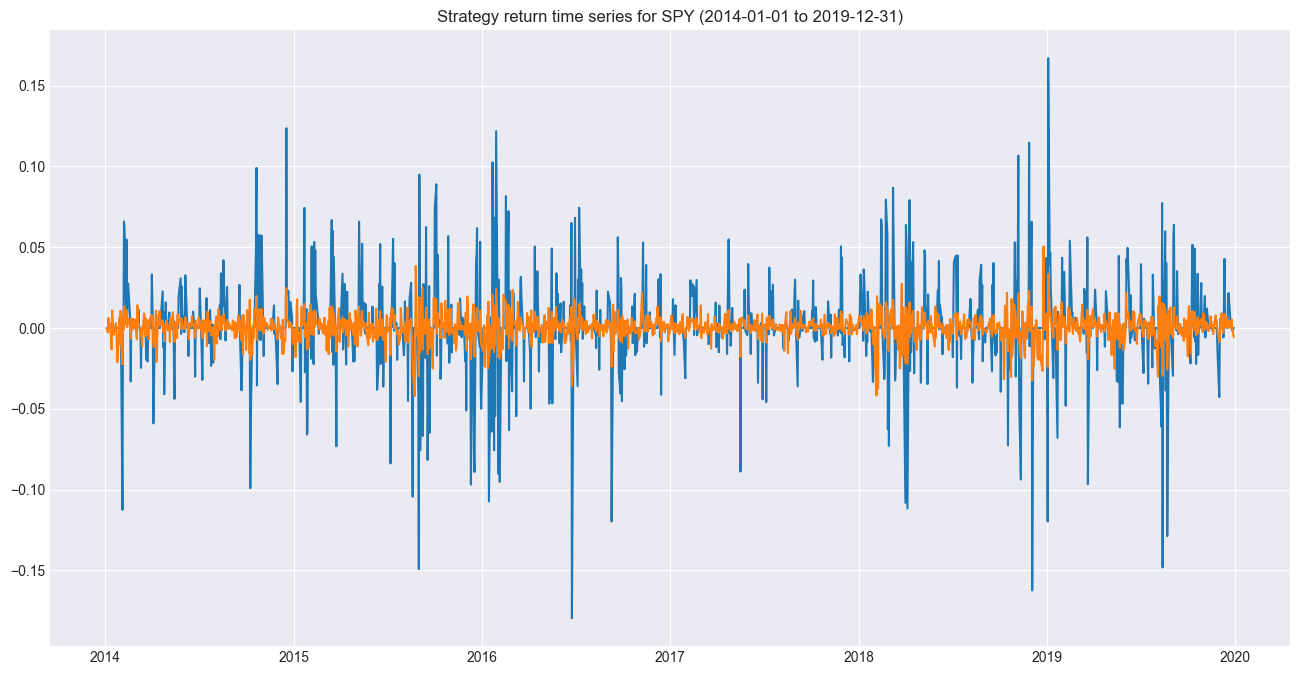

In [ ]:
# plot the strategy return

plt.figure(figsize=(16, 8)).patch.set_facecolor('w')
plt.title('Strategy return time series for SPY (2014-01-01 to 2019-12-31)')
plt.plot(spy['Strategy Return'])
plt.plot(spy['Excess Return'])
plt
plt.show()


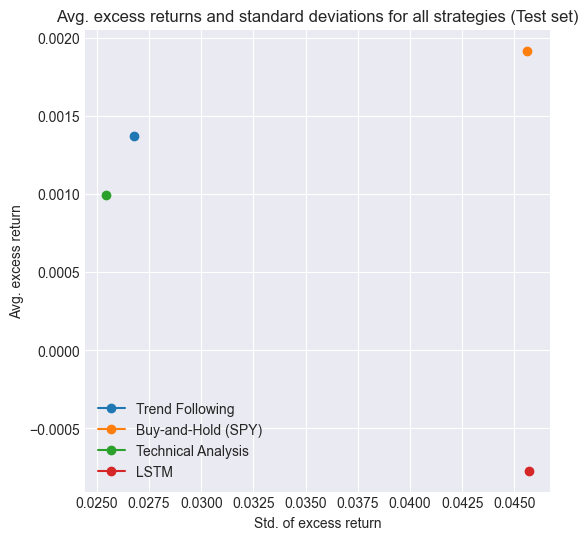

0.026793070147554332 0.0013715146543925756


In [35]:
plt.figure(figsize=(6, 6)).patch.set_facecolor('w')
plt.title('Avg. excess returns and standard deviations for all strategies (Test set)')
plt.plot(spy_test['Strategy Return'].std(), spy_test['Strategy Return'].mean(), label = 'Trend Following', marker = 'o')
plt.plot(0.045609208187419294, 0.0019167188095106616, label = 'Buy-and-Hold (SPY)', marker = 'o')
plt.plot(0.025449619047261153, 0.0009905164546484965, label = 'Technical Analysis', marker = 'o')
plt.plot(0.045692985846304913, -0.0007695616155129153, label = 'LSTM', marker = 'o')
plt.ylabel('Avg. excess return')
plt.xlabel('Std. of excess return')
plt.legend(loc = 'lower left')
plt.show()
print(spy_test['Strategy Return'].std(), spy_test['Strategy Return'].mean())

In [36]:
(0.0019167188095106616/0.0013715146543925756)/((0.045609208187419294/0.026793070147554332)**2)

0.48227844225944705